## Pre-trained models using keras
Chapter 5 from [Deep Learning: Image Recognition course](https://www.linkedin.com/learning/deep-learning-image-recognition/pre-trained-neural-networks-included-with-keras) on Linkedin Learning.

In [23]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing import image
from keras.applications import vgg16
import numpy as np
from pathlib import Path
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Download vgg16 pre-trained model.

In [2]:
model = vgg16.VGG16()

Open image, convert it to array and add one more dimension to feed it to keras.

In [3]:
img = image.load_img('./img/bay.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

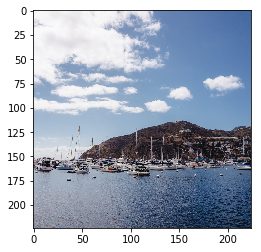

In [4]:
pylab.imshow(img)

Normalize vector values using built-in vgg function.

In [5]:
x = vgg16.preprocess_input(x)

Make prediction and show top 9 predictions.

In [6]:
pred = model.predict(x)

In [7]:
predicted_class = vgg16.decode_predictions(pred, top=9)

In [8]:
print("Top predictors:")
for img_id, name, prob in predicted_class[0]:
    print("Prediction: {} - {:f}".format(name, prob))

Top predictors:
Prediction: seashore - 0.395212
Prediction: promontory - 0.326130
Prediction: lakeside - 0.119613
Prediction: breakwater - 0.062801
Prediction: sandbar - 0.045267
Prediction: cliff - 0.011845
Prediction: dock - 0.009196
Prediction: boathouse - 0.003278
Prediction: valley - 0.003194


### Dog or Not-dog using pre-trained NN. Transfer Learning.

Reuse an existing neural network which was learnt on some data. We can take convolutional layers and cut off dense and output layers. The convolutional layers will be a feature extractor for a new model.

In [9]:
dog_path = Path('./dogs')
not_dog_path = Path('./not_dogs')

Read training images and label them.

In [10]:
images = []
labels = []
for img in not_dog_path.glob("*.png"):
    tmp_img = image.load_img(img)
    image_array = image.img_to_array(tmp_img)
    images.append(image_array)
    # use label 0 for not-dogs 
    labels.append(0)

for img in dog_path.glob("*.png"):
    tmp_img = image.load_img(img)
    image_array = image.img_to_array(tmp_img)
    images.append(image_array)
    # use label 1 for dogs 
    labels.append(1)

In [11]:
x_train = np.array(images)
y_train = np.array(labels)

Use imagenet pre-trained neural network's convolutional layers (excluding last dense layer) to make feature selection based on imagenet.

In [12]:
pretrained_nn = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

We will use the output of the imagenet convolutional layers as an input for our dense layer.

In [13]:
features_x = pretrained_nn.predict(x_train)

Create Dense Layer as a separate NN with input_shape of *features_x*.

In [15]:
model = Sequential()
model.add(Flatten(input_shape=features_x.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.fit(features_x, y_train, epochs=10, shuffle=True)

Epoch 1/10
58/58 [==============================] - 1s 12ms/step - loss: 5.6656 - acc: 0.5862
Epoch 2/10
58/58 [==============================] - 0s 379us/step - loss: 3.7255 - acc: 0.6552
Epoch 3/10
58/58 [==============================] - 0s 414us/step - loss: 2.1666 - acc: 0.7931
Epoch 4/10
58/58 [==============================] - 0s 362us/step - loss: 1.9504 - acc: 0.8793
Epoch 5/10
58/58 [==============================] - 0s 413us/step - loss: 1.4354 - acc: 0.8966
Epoch 6/10
58/58 [==============================] - 0s 379us/step - loss: 0.7129 - acc: 0.9483
Epoch 7/10
58/58 [==============================] - 0s 431us/step - loss: 0.2749 - acc: 0.9828
Epoch 8/10
58/58 [==============================] - 0s 379us/step - loss: 0.8279 - acc: 0.9483
Epoch 9/10
58/58 [==============================] - 0s 379us/step - loss: 0.4730 - acc: 0.9655
Epoch 10/10
58/58 [==============================] - 0s 414us/step - loss: 0.5540 - acc: 0.9655


In [19]:
model_structure = model.to_json()
f = Path('model_structure.json')
f.write_text(model_structure)

1360

In [20]:
model.save_weights("model_weights.h5")

Make prediction using the model.

In [22]:
model_structure = f.read_text()

In [25]:
model = model_from_json(model_structure)
model.load_weights("model_weights.h5")

In [35]:
def make_prediction(img_path, model):
    img = image.load_img(img_path, target_size=(64,64))
    image_array = image.img_to_array(img)
    images = np.expand_dims(image_array, axis=0)
    images = vgg16.preprocess_input(images)
    pylab.imshow(img)
    feat_extr_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    features = feat_extr_model.predict(images)
    result = model.predict(features)
    print("This is a dog with {}% probability".format(int(result[0][0] * 100)))

This is a dog with 100% probability


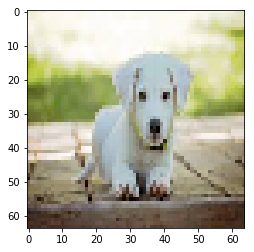

In [36]:
make_prediction('test_dog.jpg', model)

This is a dog with 0% probability


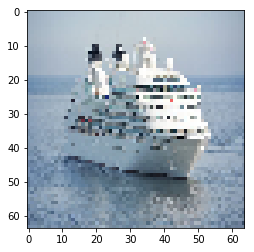

In [37]:
make_prediction('ship.jpg', model)